# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

# Bitcoin Price Forecasting using RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


## Load and Preprocess Data

In [2]:
# Load dataset
df = pd.read_csv("Bitcoin Historical Data6.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df = df.sort_values('Date')
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Normalize prices
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_prices, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Exploratory Data Analysis (EDA)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5014 entries, 5013 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5014 non-null   datetime64[ns]
 1   Price     5014 non-null   float64       
 2   Open      5014 non-null   object        
 3   High      5014 non-null   object        
 4   Low       5014 non-null   object        
 5   Vol.      5008 non-null   object        
 6   Change %  5014 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 313.4+ KB
None

Summary Statistics:
                      Date         Price
count                 5014   5014.000000
mean   2017-05-28 12:00:00  10987.032369
min    2010-07-18 00:00:00      0.100000
25%    2013-12-22 06:00:00    227.775000
50%    2017-05-28 12:00:00   2233.800000
75%    2020-11-01 18:00:00  16176.525000
max    2024-04-08 00:00:00  73066.300000
std                    NaN  16186.048994


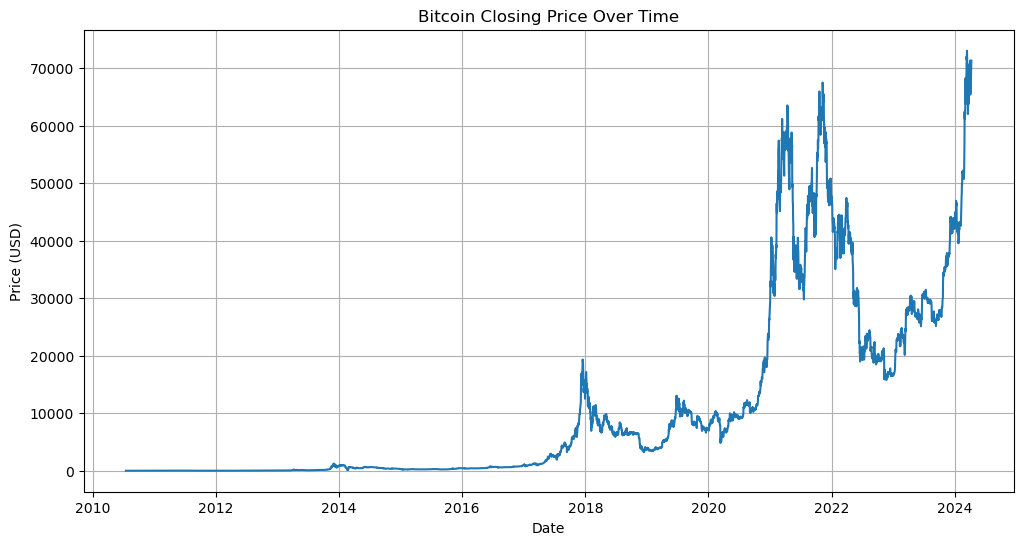

In [3]:
# Display basic info
print("Dataset Info:")
print(df.info())

# Show summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Plot Price over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'])
plt.title("Bitcoin Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


## Prepare Data Loaders

In [4]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)


## Define RNN Model

In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.view(-1, seq_length, 1)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Train Loss = {running_loss / len(train_loader):.4f}")


Epoch 1: Train Loss = 0.0117
Epoch 2: Train Loss = 0.0272
Epoch 3: Train Loss = 0.0221
Epoch 4: Train Loss = 0.0183
Epoch 5: Train Loss = 0.0141
Epoch 6: Train Loss = 0.0073
Epoch 7: Train Loss = 0.0021
Epoch 8: Train Loss = 0.0014
Epoch 9: Train Loss = 0.0022
Epoch 10: Train Loss = 0.0004
Epoch 11: Train Loss = 0.0005
Epoch 12: Train Loss = 0.0011
Epoch 13: Train Loss = 0.0020
Epoch 14: Train Loss = 0.0019
Epoch 15: Train Loss = 0.0029
Epoch 16: Train Loss = 0.0018
Epoch 17: Train Loss = 0.0018
Epoch 18: Train Loss = 0.0015
Epoch 19: Train Loss = 0.0035
Epoch 20: Train Loss = 0.0017


## Evaluate the Model

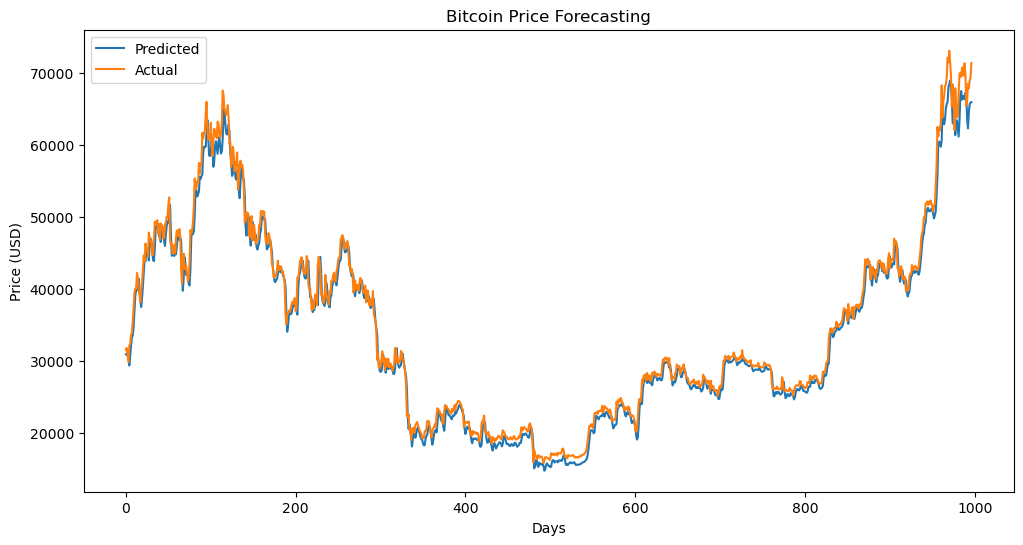

In [7]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.view(-1, seq_length, 1).to(device)
    preds = model(X_test_tensor).cpu().numpy()

preds_rescaled = scaler.inverse_transform(preds)
y_true_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(preds_rescaled, label='Predicted')
plt.plot(y_true_rescaled, label='Actual')
plt.legend()
plt.title("Bitcoin Price Forecasting")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.show()


## Compute RMSE and MAE

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverse transform predictions and true values
preds_rescaled = scaler.inverse_transform(preds)
y_true_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true_rescaled, preds_rescaled))
mae = mean_absolute_error(y_true_rescaled, preds_rescaled)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Root Mean Squared Error (RMSE): 1603.86
Mean Absolute Error (MAE): 1175.98


## Answers

#### 1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
A Recurrent Neural Network (RNN) is a type of neural network specifically designed to work with sequential data, like time series or text. Unlike feedforward neural networks, RNNs have loops that allow information to persist.

Key Components:
- Input vector (xₜ): The data at time step t.

- Hidden state (hₜ): Memory that captures information from previous time steps.

- Output (yₜ): The prediction or classification at time step t.

- Recurrent weights: Shared weights that are applied across all time steps.

Difference from Feedforward Networks:
- Feedforward Networks treat each input independently.

- RNNs maintain a hidden state that gets updated with each new input, allowing them to "remember" past inputs.



#### 2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
The recurrent connection is the link from the previous hidden state (hₜ₋₁) to the current one (hₜ). It acts as memory, enabling the network to:

- Preserve context across steps (e.g., word meaning in a sentence).

- Model dependencies in time series (e.g., stock price patterns).

This feedback loop allows the RNN to process sequences one element at a time, updating its understanding as it goes.

#### 3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
These are problems that arise during backpropagation through time (BPTT) in RNNs.

- Vanishing Gradients: Gradients become very small, making it hard for the network to learn long-range dependencies.

- Exploding Gradients: Gradients become very large, causing unstable updates and model divergence.

Both problems hurt learning and are more severe in deep or long-sequence RNNs.

#### 4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?

LSTM is a specialized RNN designed to remember long-term dependencies and fix vanishing gradient issues.

Key Components:
- Forget gate (fₜ): Decides what information to discard.

- Input gate (iₜ): Decides what new information to store.

- Output gate (oₜ): Decides what part of the cell state to output.

- Cell state (Cₜ): Acts as a memory conveyor belt.

Why it works: LSTM maintains a more stable gradient during training by allowing constant error flow through its cell state.

#### 5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.

The number of fates in LSTM i s3 i.e. input, forget, output whereas GRU has 2 gates i.e. update and reset.
There are no memory cells in GRU but there is memory cell in LSTM. The complexity is high in LSTM and lower in GRU, And th performance is similar in many tasks in LSTM and faster in GRU.

#### 6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
The hidden state (hₜ) stores past information needed to make predictions at time t. It acts like the memory of the network.

Update Process:
1. Combine the new input (xₜ) and previous hidden state (hₜ₋₁).

2. Apply weights and activation function (like tanh).

3. Update hₜ.

This update is repeated for every element in the sequence, allowing the network to "think step-by-step."

#### 7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?

For Time Series Forecasting:
- MAE (Mean Absolute Error)

- RMSE (Root Mean Squared Error)

- MAPE (Mean Absolute Percentage Error)

For Language Tasks:
- Perplexity (used in language modeling)

- Accuracy (for classification)

- BLEU score (for machine translation)

Each metric measures how well the RNN is capturing the pattern in sequential data.


#### 8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
Preprocessing is crucial to help RNNs learn efficiently.

For Time Series:
- Normalization (e.g., MinMaxScaler)

- Sequence generation (sliding windows)

- Removing outliers or noise

For Text:
- Tokenization

- Lowercasing and stopword removal

- Padding sequences

- Word embeddings (Word2Vec, GloVe)

Good preprocessing ensures consistent input shapes and meaningful patterns for the RNN to learn.

#### 9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
In Seq2Seq, an encoder RNN reads the input sequence and a decoder RNN generates the output sequence.

Applications:
- Machine Translation: English → French

- Chatbots: User input → Bot response

- Summarization: Long text → Short summary

Seq2Seq models allow RNNs to handle input and output sequences of different lengths.


#### 10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.

General Approach:
1. Train an RNN (or LSTM/GRU) to predict the next value(s) in the sequence.

2. Measure prediction error.

3. Flag anomalies when error exceeds a threshold.

Why it works:
RNNs learn normal temporal patterns — when something unusual happens, they make larger mistakes.

Used in:

- Credit card fraud detection

- Sensor malfunction in IoT

- Cybersecurity monitoring


